In [1]:
import os

In [2]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [3]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import math
import string

import tf_utils as tfu

In [4]:
strategy = tfu.strategy.cpu()

---
# Load Data

In [5]:
!wget https://www.cs.mtsu.edu/~jphillips/courses/CSCI4850-5850/public/PandP_Jane_Austen.txt
with open('PandP_Jane_Austen.txt', 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
# Paragraphs are separated by blank
# lines -> just drop those lines...
text = []
for i in range(len(lines)):
     if lines[i] != '':
        text = text + [lines[i]]
data = np.vstack([[text[0:-1]],[text[1:]]]).T
data.shape

--2022-07-14 11:51:00--  https://www.cs.mtsu.edu/~jphillips/courses/CSCI4850-5850/public/PandP_Jane_Austen.txt
Resolving www.cs.mtsu.edu (www.cs.mtsu.edu)... 161.45.162.100
Connecting to www.cs.mtsu.edu (www.cs.mtsu.edu)|161.45.162.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 683838 (668K) [text/plain]
Saving to: ‘PandP_Jane_Austen.txt.2’

PandP_Jane_Austen.t 100%[===================>] 667.81K  --.-KB/s    in 0.06s   

2022-07-14 11:51:00 (11.7 MB/s) - ‘PandP_Jane_Austen.txt.2’ saved [683838/683838]



(10657, 2)

In [6]:
n_seq = 100
split_point = 80
data = data[0:n_seq]
np.random.shuffle(data) # In-place modification
max_length = np.max([len(i) for i in data.flatten()]) + 2 # Add start/stop
max_length

74

---
# Encode Sequences

In [7]:
def encode_seq(x,mapping,max_length=0):
    # String to integer
    return [mapping['<START>']] + \
    [mapping[i] for i in list(x)] + \
    [mapping['<STOP>']] + \
    [0]*(max_length-len(list(x))-2)
def decode_seq(x,mapping):
    # Integer-to-string
    try:
        idx = list(x).index(2) # Stop token?
    except:
        idx = len(list(x)) # No stop token found
    return ''.join([mapping[i] for i in list(x)[0:idx]])

In [8]:
i_to_c_pandp = ['','<START>','<STOP>'] + list({char for word in data[:,0] for char in word})
c_to_i_pandp = {i_to_c_pandp[i]:i for i in range(len(i_to_c_pandp))}
i_to_c_pandp[1] = i_to_c_pandp[2] = ''

In [9]:
X = np.vstack([encode_seq(x,c_to_i_pandp,max_length) for x in data[:,0]])
Y = np.vstack([encode_seq(x,c_to_i_pandp,max_length) for x in data[:,1]])
x_train = X[:split_point]
x_test = X[split_point:]
pre_y_train = Y[:,0:-1][:split_point]
pre_y_test = Y[:,0:-1][split_point:]
post_y_train = Y[:,1:][:split_point]
post_y_test = Y[:,1:][split_point:]

In [10]:
x_train.shape

(80, 74)

In [11]:
pre_y_train[0]

array([ 1, 36, 51,  3, 29,  8, 50, 33, 11, 23, 19, 28, 51, 11, 11, 35, 33,
       36,  6, 19, 35, 50, 23, 19, 23, 20,  9, 51, 26, 33, 19, 37, 51, 23,
       19, 55, 35, 23, 35, 50, 35, 45, 29, 19, 51, 45, 36, 19, 45, 33, 37,
       23, 40,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0])

In [12]:
post_y_train[0]

array([36, 51,  3, 29,  8, 50, 33, 11, 23, 19, 28, 51, 11, 11, 35, 33, 36,
        6, 19, 35, 50, 23, 19, 23, 20,  9, 51, 26, 33, 19, 37, 51, 23, 19,
       55, 35, 23, 35, 50, 35, 45, 29, 19, 51, 45, 36, 19, 45, 33, 37, 23,
       40,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0])

In [13]:
x_train

array([[ 1, 23,  8, ...,  0,  0,  0],
       [ 1, 44, 51, ..., 29,  2,  0],
       [ 1, 20, 17, ..., 45,  2,  0],
       ...,
       [ 1, 39, 14, ..., 20, 11,  2],
       [ 1, 39, 25, ...,  0,  0,  0],
       [ 1, 32, 11, ...,  0,  0,  0]])

In [14]:
x_flattened = x_train.flatten()
pre_y_flattened = pre_y_train.flatten()
post_y_flattened = post_y_train.flatten()
print(x_flattened, '\n', pre_y_flattened, '\n', post_y_flattened)

[ 1 23  8 ...  0  0  0] 
 [ 1 36 51 ... 51 36  2] 
 [36 51  3 ... 36  2  0]


---
# Flatten Data

In [15]:
x_flattened = x_flattened[x_flattened != 0]
x_flattened = x_flattened[x_flattened != 1]
x_flattened = x_flattened[x_flattened != 2]

pre_y_flattened = pre_y_flattened[pre_y_flattened != 0]
pre_y_flattened = pre_y_flattened[pre_y_flattened != 1]
pre_y_flattened = pre_y_flattened[pre_y_flattened != 2]

post_y_flattened = post_y_flattened[post_y_flattened != 0]
post_y_flattened = post_y_flattened[post_y_flattened != 1]
post_y_flattened = post_y_flattened[post_y_flattened != 2]

--- 
# Batch Parameters

In [16]:
seed = 0
rng = np.random.default_rng(seed)
batch_size = 4
block_size = 5
seq_len = 20

In [17]:
if block_size > seq_len:
    raise ValueError("Block size should not be bigger than sequence length")

---
# Data Variables

In [18]:
maxlen = seq_len + 2 #Add start/stop tokens
vocab_size = len(i_to_c_pandp)
num_chars_data = x_flattened.shape[0]

In [19]:
print(maxlen)
print(vocab_size)
print(num_chars_data)

22
57
4548


---
# Generate Batch

In [20]:
rng = np.random.default_rng()
def Partial_Batch(dataset, pre_y, post_y, num_chars, seq_len, rng):
    rints = rng.integers(low=0, high=num_chars-seq_len, size=1)[0]
    
    end_x = rints + seq_len
    end_y = end_x + seq_len
    
    x = dataset[rints:end_x]
    x = np.insert(x, 0, 1)
    x = np.insert(x, x.shape[0], 2)
    
    pre_y = dataset[end_x:end_y]
    pre_y = np.insert(pre_y, 0, 1)
    pre_y[-1] = 2
    
    post_y = dataset[end_x:end_y]
    post_y = np.insert(post_y, post_y.shape[0], 2)
    
    batch = [x, pre_y, post_y]    
    
    batch = tf.keras.preprocessing.sequence.pad_sequences(batch, maxlen=maxlen, padding='post', value=0)

    padding = maxlen + (block_size-(maxlen%block_size))
                        
    if (batch.shape[1] % block_size) != 0:
        batch = tf.keras.preprocessing.sequence.pad_sequences(batch, maxlen=padding, padding='post', value=0)
   
    return batch

In [21]:
def Full_Batch(batch_size, x, pre_y, post_y, num_chars, seq_len, rng):
    x0 = []
    y1 = []
    y2 = []
    
    for i in range(batch_size):
        a, b, c, = Partial_Batch(x, pre_y, post_y, num_chars, seq_len, rng)
    
        x0.append(a)
        y1.append(b)
        y2.append(c) 
    
    return np.asarray(x0), np.asarray(y1), np.asarray(y2)

In [22]:
a,b,c = Full_Batch(batch_size, x_flattened, pre_y_flattened, post_y_flattened, num_chars_data, seq_len, rng)

In [23]:
seq_len_padded = a.shape[1]

In [24]:
print(seq_len_padded)

25


---
# Masked Transformer Block

In [25]:
class MaskedTransformerBlock(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(MaskedTransformerBlock, self).__init__()
        self.att1 = keras.layers.MultiHeadAttention(num_heads=num_heads,
        key_dim=embed_dim)
        self.att2 = keras.layers.MultiHeadAttention(num_heads=num_heads,
        key_dim=embed_dim)
        self.ffn = keras.Sequential(
        [keras.layers.Dense(ff_dim, activation="gelu"),
        keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)
        self.dropout3 = keras.layers.Dropout(rate)
    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
        )
        return tf.tile(mask, mult)
    def call(self, inputs, training):
        input_shape = tf.shape(inputs[0])
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        mask = self.causal_attention_mask(batch_size,
        seq_len, seq_len,
        tf.bool)
        attn_output1 = self.att1(inputs[0], inputs[0],
        attention_mask = mask)
        attn_output1 = self.dropout1(attn_output1, training=training)
        out1 = self.layernorm1(inputs[0] + attn_output1)
        attn_output2 = self.att2(out1, inputs[1])
        attn_output2 = self.dropout2(attn_output2, training=training)
        out2 = self.layernorm1(out1 + attn_output2)
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        return self.layernorm2(out2 + ffn_output)

---
# Masked Token and Position Embedding

In [26]:
class MaskedTokenAndPositionEmbedding(keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, **kwargs):
        super(MaskedTokenAndPositionEmbedding, self).__init__(**kwargs)
        self.token_emb = keras.layers.Embedding(input_dim=vocab_size,
        output_dim=embed_dim,
        mask_zero=True)
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen+1,
        output_dim=embed_dim,
        mask_zero=True)
    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=1, limit=maxlen+1, delta=1)
        positions = positions * tf.cast(tf.sign(x),tf.int32)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

---
# Custom Loss and Accuracy

In [27]:
with strategy.scope():
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def MaskedSparseCategoricalCrossentropy(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)
def MaskedSparseCategoricalAccuracy(real, pred):
    accuracies = tf.equal(tf.cast(real,tf.int64), tf.argmax(pred, axis=2))
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)
    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

---
# Setup

In [28]:
def clone_initializer(initializer):
    if isinstance(initializer, tf.keras.initializers.Initializer):
        return initializer.__class__.from_config(initializer.get_config())
    return initializer

In [29]:
def get_shape_list(tensor, expected_rank=None, name=None):
    if expected_rank is not None:
        assert_rank(tensor, expected_rank, name)

    shape = tensor.shape.as_list()

    non_static_indexes = []
    for (index, dim) in enumerate(shape):
        if dim is None:
            non_static_indexes.append(index)

    if not non_static_indexes:
        return shape

    dyn_shape = tf.shape(tensor)
    for index in non_static_indexes:
        shape[index] = dyn_shape[index]
    return shape

---
# Cache Memory

In [30]:
# current_state: `Tensor`, the current state.
# previous_state: `Tensor`, the previous state.
# memory_length: `int`, the number of tokens to cache.
# reuse_length: `int`, the number of tokens in the current batch to be cached
#     and reused in the future.
# Returns:  `Tensor`, representing the cached state with stopped gradients.
def _cache_memory(current_state, previous_state, memory_length, reuse_length=0):
    if memory_length is None or memory_length == 0:
        return None
    else:
        if reuse_length > 0:
            current_state = current_state[:, :reuse_length, :]

        if previous_state is None:
            new_mem = current_state[:, -memory_length:, :]
        else:
            new_mem = tf.concat(
                    [previous_state, current_state], 1)[:, -memory_length:, :]

    return tf.stop_gradient(new_mem)

---
# MultiHead Attention

In [188]:
# query: Query `Tensor` of shape `[B, T, dim]`.
# value: Value `Tensor` of shape `[B, S, dim]`.
# content_attention_bias: Bias `Tensor` for content based attention of shape
# `[num_heads, dim]`.
# positional_attention_bias: Bias `Tensor` for position based attention of
# shape `[num_heads, dim]`.
# key: Optional key `Tensor` of shape `[B, S, dim]`. If not given, will use
# `value` for both `key` and `value`, which is the most common case.
# relative_position_encoding: Relative positional encoding `Tensor` of shape
# `[B, L, dim]`.
# state: Optional `Tensor` of shape `[B, M, E]` where M is the length of the
# state or memory. If passed, this is also attended over as in Transformer
# XL.
# attention_mask: A boolean mask of shape `[B, T, S]` that prevents attention
# to certain positions.
class MultiHeadRelativeAttention(tf.keras.layers.MultiHeadAttention):
    def __init__(self,
                 kernel_initializer="variance_scaling",
                 **kwargs):
        super().__init__(kernel_initializer=kernel_initializer,
                                         **kwargs)

    def _build_from_signature(self, query, value, key=None):
        super(MultiHeadRelativeAttention, self)._build_from_signature(
                query=query,
                value=value,
                key=key)
        if hasattr(value, "shape"):
            value_shape = tf.TensorShape(value.shape)
        else:
            value_shape = value
        if key is None:
            key_shape = value_shape
        elif hasattr(key, "shape"):
            key_shape = tf.TensorShape(key.shape)
        else:
            key_shape = key

        common_kwargs = dict(
                kernel_initializer=self._kernel_initializer,
                bias_initializer=self._bias_initializer,
                kernel_regularizer=self._kernel_regularizer,
                bias_regularizer=self._bias_regularizer,
                activity_regularizer=self._activity_regularizer,
                kernel_constraint=self._kernel_constraint,
                bias_constraint=self._bias_constraint)

        with tf.init_scope():
            einsum_equation, _, output_rank = _build_proj_equation(
                    key_shape.rank - 1, bound_dims=1, output_dims=2)
            self._encoding_dense = tf.keras.layers.experimental.EinsumDense(
                    einsum_equation,
                    output_shape=_get_output_shape(
                        output_rank - 1,
                        [self._num_heads, self._key_dim]),
                        bias_axes=None,
                        name="encoding",
                        **common_kwargs)

# query: Projected query `Tensor` of shape `[B, T, N, key_dim]`.
# key: Projected key `Tensor` of shape `[B, S + M, N, key_dim]`.
# value: Projected value `Tensor` of shape `[B, S + M, N, key_dim]`.
# position: Projected position `Tensor` of shape `[B, L, N, key_dim]`.
# content_attention_bias: Trainable bias parameter added to the query head
#     when calculating the content-based attention score.
# positional_attention_bias: Trainable bias parameter added to the query
#     head when calculating the position-based attention score.
# attention_mask: (default None) Optional mask that is added to attention
#     logits. If state is not None, the mask source sequence dimension should
#     extend M.
# Returns:
# attention_output: Multi-headed output of attention computation of shape
#     `[B, S, N, key_dim]`.
    def compute_attention(
        self,
        query,
        key,
        value,
        position,
        content_attention_bias,
        positional_attention_bias,
        attention_mask=None
    ):
        
        tf.print(query.shape)
        tf.print(key.shape)
        tf.print(value.shape)
        #AC
        content_attention = tf.einsum(self._dot_product_equation, key, query + content_attention_bias)
        
        positional_attention = tf.einsum(self._dot_product_equation, position, query + positional_attention_bias)
        
        #BD
        positional_attention = _rel_shift(positional_attention, klen=tf.shape(content_attention)[3])
        
        tf.print(content_attention.shape, positional_attention.shape)
        
        attention_sum = content_attention + positional_attention

        attention_scores = tf.multiply(attention_sum, 1.0 / math.sqrt(float(self._key_dim)))

        attention_scores = self._masked_softmax(attention_scores, attention_mask)

        attention_output = self._dropout_layer(attention_scores)

        attention_output = tf.einsum(self._combine_equation,
                                                                 attention_output,
                                                                 value)
        return attention_output

# * Number of heads (H): the number of attention heads.
# * Value size (V): the size of each value embedding per head.
# * Key size (K): the size of each key embedding per head. Equally, the size
#     of each query embedding per head. Typically K <= V.
# * Batch dimensions (B).
# * Query (target) attention axes shape (T).
# * Value (source) attention axes shape (S), the rank must match the target.
# * Encoding length (L): The relative positional encoding length.
# query: attention input.
# value: attention input.
# content_attention_bias: A trainable bias parameter added to the query head
#     when calculating the content-based attention score.
# positional_attention_bias: A trainable bias parameter added to the query
#     head when calculating the position-based attention score.
# key: attention input.
# relative_position_encoding: relative positional encoding for key and
#     value.
# state: (default None) optional state. If passed, this is also attended
#     over as in TransformerXL.
# attention_mask: (default None) Optional mask that is added to attention
#     logits. If state is not None, the mask source sequence dimension should
#     extend M.
# Returns:
# attention_output: The result of the computation, of shape [B, T, E],
#     where `T` is for target sequence shapes and `E` is the query input last
#     dimension if `output_shape` is `None`. Otherwise, the multi-head outputs
#     are projected to the shape specified by `output_shape`.
    def call(self,
             query,
             value,
             content_attention_bias,
             positional_attention_bias,
             key=None,
             relative_position_encoding=None,
             state=None,
             attention_mask=None):
        
        if not self._built_from_signature:
            self._build_from_signature(query, value, key=key)
        if key is None:
            key = value
        if state is not None and state.shape.ndims > 1:
            value = tf.concat([state, value], 1)
            key = tf.concat([state, key], 1)

        # `query` = [B, T, N ,H]
        query = self._query_dense(query)

        # `key` = [B, S + M, N, H]
        key = self._key_dense(key)

        # `value` = [B, S + M, N, H]
        value = self._value_dense(value)

        # `position` = [B, L, N, H]
        position = self._encoding_dense(relative_position_encoding)

        attention_output = self.compute_attention(
                query=query,
                key=key,
                value=value,
                position=position,
                content_attention_bias=content_attention_bias,
                positional_attention_bias=positional_attention_bias,
                attention_mask=attention_mask)

        # `attention_output` = [B, S, N, H]
        attention_output = self._output_dense(attention_output)

        return attention_output

---
# Relative Shift

In [189]:
def _rel_shift(x, klen=-1):    
    x = tf.transpose(x, perm=[2, 3, 0, 1])
    x = tf.pad(x, [[0, 0], [1, 0], [0, 0], [0, 0]])
    x_size = tf.shape(x)
    x = tf.reshape(x, [x_size[1], x_size[0], x_size[2], x_size[3]])
    x = tf.slice(x, [1, 0, 0, 0], [-1, -1, -1, -1])
    x = tf.reshape(x, [x_size[0], x_size[1] - 1, x_size[2], x_size[3]])
    x = tf.transpose(x, perm=[2, 3, 0, 1])

    return x

---
# Build Einsum Equation

In [190]:
_CHR_IDX = string.ascii_lowercase

# Builds an einsum equation for projections inside multi-head attention
def _build_proj_equation(free_dims, bound_dims, output_dims):
    input_str = ""
    kernel_str = ""
    output_str = ""
    bias_axes = ""
    letter_offset = 0
    for i in range(free_dims):
        char = _CHR_IDX[i + letter_offset]
        input_str += char
        output_str += char

    letter_offset += free_dims
    for i in range(bound_dims):
        char = _CHR_IDX[i + letter_offset]
        input_str += char
        kernel_str += char

    letter_offset += bound_dims
    for i in range(output_dims):
        char = _CHR_IDX[i + letter_offset]
        kernel_str += char
        output_str += char
        bias_axes += char
    equation = "%s,%s->%s" % (input_str, kernel_str, output_str)

    return equation, bias_axes, len(output_str)


def _get_output_shape(output_rank, known_last_dims):
    return [None] * (output_rank - len(known_last_dims)) + list(known_last_dims)

---
# Relative Position Embedding

In [191]:
# hidden_size: Size of the hidden layer.
# min_timescale: Minimum scale that will be applied at each position
# max_timescale: Maximum scale that will be applied at each position.
class RelativePositionEmbedding(tf.keras.layers.Layer):

    def __init__(self,
                 hidden_size: int,
                 min_timescale: float = 1.0,
                 max_timescale: float = 1.0e4,
                 **kwargs):
        
        if "dtype" not in kwargs:
            kwargs["dtype"] = "float32"

        super().__init__(**kwargs)
        self._hidden_size = hidden_size
        self._min_timescale = min_timescale
        self._max_timescale = max_timescale

    def get_config(self):
        config = {
                "hidden_size": self._hidden_size,
                "min_timescale": self._min_timescale,
                "max_timescale": self._max_timescale,
        }
        base_config = super(RelativePositionEmbedding, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

# inputs: An tensor whose second dimension will be used as `length`. If
# `None`, the other `length` argument must be specified.
# length: An optional integer specifying the number of positions. If both
# `inputs` and `length` are spcified, `length` must be equal to the second
# dimension of `inputs`.
# Returns:
# A tensor in shape of `(length, hidden_size)`.
    def call(self, inputs, length=None):
        if inputs is None and length is None:
            raise ValueError("If inputs is None, `length` must be set in "
                                             "RelativePositionEmbedding().")
        if inputs is not None:
            input_shape = get_shape_list(inputs)
            if length is not None and length != input_shape[1]:
                raise ValueError(
                        "If inputs is not None, `length` must equal to input_shape[1].")
            length = input_shape[1]
        position = tf.cast(tf.range(length), tf.float32)
        num_timescales = self._hidden_size // 2
        min_timescale, max_timescale = self._min_timescale, self._max_timescale
        log_timescale_increment = (
                math.log(float(max_timescale) / float(min_timescale)) /
                (tf.cast(num_timescales, tf.float32) - 1))
        inv_timescales = min_timescale * tf.exp(
                tf.cast(tf.range(num_timescales), tf.float32) *
                -log_timescale_increment)
        scaled_time = tf.expand_dims(position, 1) * tf.expand_dims(
                inv_timescales, 0)
        position_embeddings = tf.concat(
                [tf.sin(scaled_time), tf.cos(scaled_time)], axis=1)
        position_embeddings = tf.expand_dims(position_embeddings, axis=0)
        return tf.tile(position_embeddings, (tf.shape(inputs)[0], 1, 1))

---
# XL Block

In [192]:
# vocab_size: The size of the token vocabulary.
# hidden_size: The size of the transformer hidden layers.
# num_attention_heads: The number of attention heads.
# head_size: The dimension size of each attention head.
# inner_size: The inner size for the transformer layers.
# dropout_rate: Dropout rate for the output of this layer.
# attention_dropout_rate: Dropout rate on attention probabilities.
# norm_epsilon: Epsilon value to initialize normalization layers.
# inner_activation: The activation to use for the inner
#     FFN layers.
# kernel_initializer: Initializer for dense layer kernels.
# inner_dropout: Dropout probability for the inner dropout
#     layer.
class TransformerXLBlock(tf.keras.layers.Layer):
    def __init__(self,
                 vocab_size,
                 hidden_size,
                 num_attention_heads,
                 head_size,
                 inner_size,
                 dropout_rate,
                 attention_dropout_rate,
                 norm_epsilon=1e-12,
                 inner_activation="relu",
                 kernel_initializer="variance_scaling",
                 inner_dropout=0.0,
                 **kwargs):
        """Initializes TransformerXLBlock layer."""

        super(TransformerXLBlock, self).__init__(**kwargs)
        self._vocab_size = vocab_size
        self._num_heads = num_attention_heads
        self._head_size = head_size
        self._hidden_size = hidden_size
        self._inner_size = inner_size
        self._dropout_rate = dropout_rate
        self._attention_dropout_rate = attention_dropout_rate
        self._inner_activation = inner_activation
        self._norm_epsilon = norm_epsilon
        self._kernel_initializer = kernel_initializer
        self._inner_dropout = inner_dropout
        self._attention_layer_type = MultiHeadRelativeAttention

    def build(self, input_shape):
        input_tensor = input_shape[0] if len(input_shape) == 2 else input_shape
        input_tensor_shape = tf.TensorShape(input_tensor)
        if len(input_tensor_shape.as_list()) != 3:
            raise ValueError("TransformerLayer expects a three-dimensional input of "
                                             "shape [batch, sequence, width].")
        batch_size, sequence_length, hidden_size = input_tensor_shape

        if len(input_shape) == 2:
            mask_tensor_shape = tf.TensorShape(input_shape[1])
            expected_mask_tensor_shape = tf.TensorShape(
                    [batch_size, sequence_length, sequence_length])
            if not expected_mask_tensor_shape.is_compatible_with(mask_tensor_shape):
                raise ValueError("When passing a mask tensor to TransformerXLBlock, "
                                                 "the mask tensor must be of shape [batch, "
                                                 "sequence_length, sequence_length] (here %s). Got a "
                                                 "mask tensor of shape %s." %
                                                 (expected_mask_tensor_shape, mask_tensor_shape))
        if hidden_size % self._num_heads != 0:
            raise ValueError(
                    "The input size (%d) is not a multiple of the number of attention "
                    "heads (%d)" % (hidden_size, self._num_heads))
        self._attention_layer = self._attention_layer_type(
                num_heads=self._num_heads,
                key_dim=self._head_size,
                value_dim=self._head_size,
                dropout=self._attention_dropout_rate,
                use_bias=False,
                kernel_initializer=clone_initializer(self._kernel_initializer),
                name="rel_attn")
        self._attention_dropout = tf.keras.layers.Dropout(
                rate=self._attention_dropout_rate)
        self._attention_layer_norm = tf.keras.layers.LayerNormalization(
                name="self_attention_layer_norm",
                axis=-1,
                epsilon=self._norm_epsilon,
                dtype=tf.float32)
        self._inner_dense = tf.keras.layers.experimental.EinsumDense(
                "abc,cd->abd",
                output_shape=(None, self._inner_size),
                bias_axes="d",
                kernel_initializer=clone_initializer(self._kernel_initializer),
                name="inner")

        self._inner_activation_layer = tf.keras.layers.Activation(
                self._inner_activation)
        self._inner_dropout_layer = tf.keras.layers.Dropout(
                rate=self._inner_dropout)
        self._output_dense = tf.keras.layers.experimental.EinsumDense(
                "abc,cd->abd",
                output_shape=(None, hidden_size),
                bias_axes="d",
                name="output",
                kernel_initializer=clone_initializer(self._kernel_initializer))
        self._output_dropout = tf.keras.layers.Dropout(rate=self._dropout_rate)
        self._output_layer_norm = tf.keras.layers.LayerNormalization(
                name="output_layer_norm",
                axis=-1,
                epsilon=self._norm_epsilon)

        super(TransformerXLBlock, self).build(input_shape)

    def get_config(self):
        config = {
                "vocab_size":
                        self._vocab_size,
                "hidden_size":
                        self._hidden_size,
                "num_attention_heads":
                        self._num_heads,
                "head_size":
                        self._head_size,
                "inner_size":
                        self._inner_size,
                "dropout_rate":
                        self._dropout_rate,
                "attention_dropout_rate":
                        self._attention_dropout_rate,
                "norm_epsilon":
                        self._norm_epsilon,
                "inner_activation":
                        self._inner_activation,
                "kernel_initializer":
                        self._kernel_initializer,
                "inner_dropout":
                        self._inner_dropout,
        }
        base_config = super(TransformerXLBlock, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

# content_stream: `Tensor`, the input content stream. This is the standard
# input to Transformer XL and is commonly referred to as `h` in XLNet.
# content_attention_bias: Bias `Tensor` for content based attention of shape
# `[num_heads, dim]`.
# positional_attention_bias: Bias `Tensor` for position based attention of
# shape `[num_heads, dim]`.
# relative_position_encoding: Relative positional encoding `Tensor` of shape
# `[B, L, dim]`.
# state: Optional `Tensor` of shape `[B, M, E]`, where M is the length of
# the state or memory. If passed, this is also attended over as in
# Transformer XL.
# content_attention_mask: Optional `Tensor` representing the mask that is
# added to content attention logits. If state is not None, the mask source
# sequence dimension should extend M.
# query_attention_mask: Optional `Tensor` representing the mask that is
# added to query attention logits. If state is not None, the mask source
# sequence dimension should extend M.
# target_mapping: Optional `Tensor` representing the target mapping when
# calculating query attention.
# Returns:
# A `dict` object, containing the key value pairs for `content_attention`
    def call(self,
             content_stream,
             content_attention_bias,
             positional_attention_bias,
             relative_position_encoding=None,
             state=None,
             content_attention_mask=None,
             query_attention_mask=None,
             target_mapping=None):
        
        attention_kwargs = dict(
                query=content_stream,
                value=content_stream,
                key=content_stream,
                attention_mask=content_attention_mask)

        common_attention_kwargs = dict(
                content_attention_bias=content_attention_bias,
                relative_position_encoding=relative_position_encoding,
                positional_attention_bias=positional_attention_bias,
                state=state)

        attention_kwargs.update(common_attention_kwargs)
        attention_output = self._attention_layer(**attention_kwargs)

        attention_stream = attention_output
        input_stream = content_stream
        attention_key = "content_attention"
        attention_output = {}
        
        attention_stream = self._attention_dropout(attention_stream)
        attention_stream = self._attention_layer_norm(attention_stream + input_stream)
        inner_output = self._inner_dense(attention_stream)
        inner_output = self._inner_activation_layer(
                inner_output)
        inner_output = self._inner_dropout_layer(
                inner_output)
        layer_output = self._output_dense(inner_output)
        layer_output = self._output_dropout(layer_output)
        layer_output = self._output_layer_norm(layer_output + attention_stream)
        attention_output[attention_key] = layer_output

        return attention_output

---
# Transformer XL

In [193]:
# num_layers: The number of layers.
# hidden_size: The hidden size.
# num_attention_heads: The number of attention heads.
# head_size: The dimension size of each attention head.
# inner_size: The hidden size in feed-forward layers.
# dropout_rate: Dropout rate used in each Transformer XL block.
# attention_dropout_rate: Dropout rate on attention probabilities.
# initializer: The initializer to use for attention biases.
# tie_attention_biases: Whether or not to tie biases together. If `True`, then
# each Transformer XL block shares the same trainable attention bias. If
# `False`, then each block has its own attention bias. This is usually set
# to `True`.
# memory_length: The number of tokens to cache.
# reuse_length: The number of tokens in the current batch to be cached
# and reused in the future.
# inner_activation: The activation to use in the inner layers
# for Transformer XL blocks. Typically "relu" or "gelu".
class TransformerXL(tf.keras.layers.Layer):
    def __init__(self,
                 vocab_size,
                 num_layers,
                 hidden_size,
                 maxlen,
                 embed_dim,
                 num_attention_heads,
                 head_size,
                 inner_size,
                 dropout_rate,
                 attention_dropout_rate,
                 initializer,
                 tie_attention_biases=True,
                 memory_length=None,
                 reuse_length=None,
                 inner_activation="relu",
                 **kwargs):
        super(TransformerXL, self).__init__(**kwargs)

        self._vocab_size = vocab_size
        self._initializer = initializer
        self._num_layers = num_layers
        self._hidden_size = hidden_size
        self._num_attention_heads = num_attention_heads
        self._head_size = head_size
        self._inner_size = inner_size
        self._inner_activation = inner_activation
        self._dropout_rate = dropout_rate
        self._attention_dropout_rate = attention_dropout_rate
        self._tie_attention_biases = tie_attention_biases

        self._memory_length = memory_length
        self._reuse_length = reuse_length

        if self._tie_attention_biases:
            attention_bias_shape = [self._num_attention_heads, self._head_size]
        else:
            attention_bias_shape = [self._num_layers, self._num_attention_heads, self._head_size]

        self.content_attention_bias = self.add_weight(
                "content_attention_bias",
                shape=attention_bias_shape,
                dtype=tf.float32,
                initializer=clone_initializer(self._initializer))
        self.positional_attention_bias = self.add_weight(
                "positional_attention_bias",
                shape=attention_bias_shape,
                dtype=tf.float32,
                initializer=clone_initializer(self._initializer))

        self.transformer_xl_layers = []
        for i in range(self._num_layers):
            self.transformer_xl_layers.append(
                    TransformerXLBlock(
                            vocab_size=self._vocab_size,
                            hidden_size=self._head_size * self._num_attention_heads,
                            num_attention_heads=self._num_attention_heads,
                            head_size=self._head_size,
                            inner_size=self._inner_size,
                            dropout_rate=self._dropout_rate,
                            attention_dropout_rate=self._attention_dropout_rate,
                            norm_epsilon=1e-12,
                            inner_activation=self._inner_activation,
                            kernel_initializer="variance_scaling",
                            name="layer_%d" % i))

        self.output_dropout = tf.keras.layers.Dropout(rate=self._dropout_rate)

    def get_config(self):
        config = {
                "vocab_size":
                        self._vocab_size,
                "num_layers":
                        self._num_layers,
                "hidden_size":
                        self._hidden_size,
                "num_attention_heads":
                        self._num_attention_heads,
                "head_size":
                        self._head_size,
                "inner_size":
                        self._inner_size,
                "dropout_rate":
                        self._dropout_rate,
                "attention_dropout_rate":
                        self._attention_dropout_rate,
                "initializer":
                        self._initializer,
                "tie_attention_biases":
                        self._tie_attention_biases,
                "memory_length":
                        self._memory_length,
                "reuse_length":
                        self._reuse_length,
                "inner_activation":
                        self._inner_activation,
        }
        base_config = super(TransformerXL, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

# content_stream: `Tensor`, the input content stream. This is the standard
# input to Transformer XL and is commonly referred to as `h` in XLNet.
# relative_position_encoding: Relative positional encoding `Tensor` of shape
# `[B, L, dim]`.
# state: Optional `Tensor` of shape `[B, M, E]`, where M is the length of
# the state or memory. If passed, this is also attended over as in
# Transformer XL.
# content_attention_mask: Optional `Tensor` representing the mask that is
# added to content attention logits. If state is not None, the mask source
# sequence dimension should extend M.
# query_attention_mask: Optional `Tensor` representing the mask that is
# added to query attention logits. If state is not None, the mask source
# sequence dimension should extend M.
# target_mapping: Optional `Tensor` representing the target mapping when
# calculating query attention.
# Returns:
# A tuple consisting of the attention output and the list of cached memory
# states.
# The attention output is `content_attention`
    def call(self,
             content_stream,
             relative_position_encoding,
             state=None,
             content_attention_mask=None,
             query_attention_mask=None,
             target_mapping=None):
        
        new_mems = []

        if state is None:
            state = [None] * self._num_layers
        for i in range(self._num_layers):
            # cache new mems
            new_mems.append(
                    _cache_memory(content_stream, state[i],
                                                self._memory_length, self._reuse_length))
            
            tf.print(state[i].shape)
            if self._tie_attention_biases:
                content_attention_bias = self.content_attention_bias
            else:
                content_attention_bias = self.content_attention_bias[i]
                
            if self._tie_attention_biases:
                positional_attention_bias = self.positional_attention_bias
            else:
                positional_attention_bias = self.positional_attention_bias[i]

            transformer_xl_layer = self.transformer_xl_layers[i]
            
            transformer_xl_output = transformer_xl_layer(
                    content_stream=content_stream,
                    content_attention_bias=content_attention_bias,
                    positional_attention_bias=positional_attention_bias,
                    relative_position_encoding=relative_position_encoding,
                    state=state[i],
                    content_attention_mask=content_attention_mask,
                    query_attention_mask=query_attention_mask,
                    target_mapping=target_mapping)
            content_stream = transformer_xl_output["content_attention"]

        output_stream = content_stream
        return output_stream, new_mems

---
# Xl Model Class

In [194]:
class XlModel(keras.Model):
    def __init__(self, block_size, seq_len_padded, embed_dim, vocab_size, num_layers, hidden_size, num_attention_heads, maxlen, memory_length, reuse_length, head_size, inner_size, dropout_rate, attention_dropout_rate, initializer):
        super(XlModel, self).__init__()
        
        self.block_size = block_size
        self.seq_len_padded = seq_len_padded
        self.embed_dim = embed_dim
        self.num_heads = num_attention_heads
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.maxlen = maxlen
        self.memory_length = memory_length
        
        self.embedding_layer = MaskedTokenAndPositionEmbedding(maxlen=maxlen, vocab_size=vocab_size, embed_dim=embed_dim)
        
        self.rel_embeddings = RelativePositionEmbedding(embed_dim)

        self.transformer_xl = TransformerXL(
                vocab_size=vocab_size,
                num_layers=num_layers,
                hidden_size=hidden_size,
                num_attention_heads=num_attention_heads,
                maxlen=maxlen,
                embed_dim=embed_dim,
                memory_length=memory_length,
                reuse_length=reuse_length,
                head_size=head_size,
                inner_size=inner_size,
                dropout_rate=dropout_rate,
                attention_dropout_rate=attention_dropout_rate,
                initializer=initializer, 
            )
        
    
    def call(self, x, mems, training=None):        
        
        embeddings = self.embedding_layer(x)
        
        
        if mems[0] is not None:
            rel_embeddings = self.rel_embeddings(tf.concat((embeddings,mems[0]), axis=1))
        else:
            rel_embeddings = self.rel_embeddings(embeddings)
    
        for i in range(0, self.seq_len_padded, self.block_size):
            block = embeddings[:,i:i+block_size]
            rel_block = rel_embeddings[:,i:i+block_size]
            encoder, mems = self.transformer_xl(content_stream=block, relative_position_encoding=rel_block, state=mems)
        
        return encoder, mems

---
# Decoder Model Xl Class

In [195]:
class DecoderXl(keras.Model):
    def __init__(self, block_size, seq_len_padded, seq_len, embed_dim, vocab_size, num_layers, hidden_size, num_attention_heads, maxlen, memory_length, reuse_length, head_size, inner_size, dropout_rate, attention_dropout_rate, initializer):
        super(DecoderXl, self).__init__()
        
        self.block_size = block_size
        self.seq_len_padded = seq_len_padded
        self.seq_len = seq_len
        self.embed_dim = embed_dim
        self.num_heads = num_attention_heads
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.maxlen = maxlen
        self.memory_length = memory_length
        
        #Embedding for targets
        self.embedding_layer = MaskedTokenAndPositionEmbedding(maxlen=maxlen, vocab_size=vocab_size, embed_dim=embed_dim)
        
        #Relative embeddings for targets
        self.rel_embeddings = RelativePositionEmbedding(embed_dim)

        #Transformer xl takes in decoder memories
        self.transformer_xl = TransformerXL(
                vocab_size=vocab_size,
                num_layers=num_layers,
                hidden_size=hidden_size,
                num_attention_heads=num_attention_heads,
                maxlen=maxlen,
                embed_dim=embed_dim,
                memory_length=memory_length,
                reuse_length=reuse_length,
                head_size=head_size,
                inner_size=inner_size,
                dropout_rate=dropout_rate,
                attention_dropout_rate=attention_dropout_rate,
                initializer=initializer, 
            )
        
        #Attention between targets and encoder output
        self.x_y_attention_layer = MaskedTransformerBlock(embed_dim=embed_dim, num_heads=num_attention_heads, ff_dim=hidden_size)

        self.output_layer = keras.layers.Dense(seq_len)
        
    
    def call(self, encoder, pre_y, post_y, mems, training=None):        
        
        #Target embeddings
        embeddings = self.embedding_layer(pre_y)
        
        #Position encoding
        if mems[0] is not None:
            rel_embeddings = self.rel_embeddings(tf.concat((embeddings,mems[0]), axis=1))
        else:
            rel_embeddings = self.rel_embeddings(embeddings)
        
        decoder_output = []
        
        #Loop through target blcoks
        for i in range(0, self.seq_len_padded, self.block_size):
            block = embeddings[:,i:i+block_size]
            rel_block = rel_embeddings[:,i:i+block_size]
            
            decoder, mems = self.transformer_xl(content_stream=block, relative_position_encoding=rel_block, state=mems)
            
            self_attention = self.x_y_attention_layer([decoder, encoder])
            
            if i == 0:
                decoder_output = self_attention
            else:
                decoder_output = tf.concat([decoder_output, self_attention], axis=1)
        
        output = self.output_layer(decoder_output)    
        
        return output, mems
    

---
# Xl Parameters

In [196]:
#Xl Parameters 
embed_dim = 64
num_layers = 8
hidden_size = 64
num_attention_heads = 8
memory_length = 20
reuse_length = 0
head_size = 32
inner_size = 32
dropout_rate = 0.0
attention_dropout_rate = 0.0
initializer = keras.initializers.RandomNormal(stddev=0.1) 

---
# Decoder Xl Parameters

In [197]:
encoder_shape = (block_size, embed_dim)

---
# Create Models

In [198]:
with strategy.scope():  
    encoder = XlModel(block_size, seq_len_padded, embed_dim, vocab_size, num_layers, hidden_size, num_attention_heads, maxlen, memory_length, reuse_length, head_size, inner_size, dropout_rate, attention_dropout_rate, initializer)
    encoder.compile(loss = MaskedSparseCategoricalCrossentropy, optimizer = keras.optimizers.Adam())
    
    decoder =  DecoderXl(block_size, seq_len_padded, seq_len, embed_dim, vocab_size, num_layers, hidden_size, num_attention_heads, maxlen, memory_length, reuse_length, head_size, inner_size, dropout_rate, attention_dropout_rate, initializer)
    decoder.compile(loss = MaskedSparseCategoricalCrossentropy, optimizer = keras.optimizers.Adam())

---
# Custom Train Step

In [199]:
#Split encoder segment up inside model
#Process one by one
#Send last output to decoder
#Split target up 
#Process one by one
#Pass in parallel one by one to mha with encoder output
#Aggregate
#Send gradients back

In [200]:
x, pre_y, post_y = Full_Batch(batch_size, x_flattened, pre_y_flattened, post_y_flattened, num_chars_data, seq_len, rng)
encoder_mems = tf.zeros((num_layers, batch_size, memory_length, embed_dim))
decoder_mems = tf.zeros((num_layers, batch_size, memory_length, embed_dim))

In [201]:
encoder_output, encoder_mems = encoder(x, encoder_mems, training=True)

TensorShape([4, 20, 64])
TensorShape([4, 5, 8, 32])
TensorShape([4, 25, 8, 32])
TensorShape([4, 25, 8, 32])
TensorShape([4, 8, 5, 25]) TensorShape([4, 8, 5, 5])


InvalidArgumentError: Exception encountered when calling layer "rel_attn" (type MultiHeadRelativeAttention).

Incompatible shapes: [4,8,5,25] vs. [4,8,5,5] [Op:AddV2]

Call arguments received:
  • query=tf.Tensor(shape=(4, 5, 64), dtype=float32)
  • value=tf.Tensor(shape=(4, 5, 64), dtype=float32)
  • content_attention_bias=<tf.Variable 'content_attention_bias:0' shape=(8, 32) dtype=float32, numpy=
array([[ 0.03287513,  0.1308676 ,  0.07159242,  0.03937121, -0.17795798,
        -0.13579169, -0.0221532 , -0.05166721, -0.09662085,  0.15133546,
        -0.05118976,  0.02578242, -0.04608143,  0.06914274, -0.10207377,
         0.20638596, -0.0872229 ,  0.15885858, -0.12725139,  0.1462176 ,
        -0.06859937,  0.09135687, -0.07438351, -0.02813614,  0.07960841,
        -0.15449849, -0.03970689,  0.20876415,  0.11723583,  0.00644691,
        -0.0389403 ,  0.04704792],
       [-0.08524917, -0.2896531 , -0.02580698,  0.01670947,  0.05169223,
         0.08683338,  0.0491168 , -0.04607744, -0.05214889,  0.02677131,
        -0.08692616, -0.07404373, -0.14667545,  0.02935993, -0.00817272,
        -0.02815646,  0.01483426, -0.04266326, -0.10919099,  0.03855965,
        -0.07222566, -0.17054842,  0.00908754, -0.0622774 ,  0.12986699,
        -0.03118214,  0.02299939, -0.00548464,  0.04589556, -0.05235977,
        -0.05871842, -0.08726641],
       [-0.06108912,  0.0438494 ,  0.04593267,  0.20173314,  0.02447603,
        -0.08227833,  0.00147641, -0.13687143,  0.2736034 , -0.01947888,
         0.04949598, -0.16006674, -0.05029876, -0.11988882,  0.16386232,
         0.02060073, -0.22690168,  0.06145889,  0.02008096, -0.19718926,
         0.01065039,  0.01022316, -0.26778615,  0.00291108,  0.03542108,
         0.05421104,  0.03103381, -0.0334777 , -0.06713177,  0.12368794,
        -0.0106899 ,  0.08349055],
       [-0.06384157, -0.08431133, -0.00934188,  0.15116042, -0.04571173,
         0.07931993, -0.04587935, -0.17895998, -0.0548207 , -0.07388108,
         0.07076109,  0.06776614, -0.10873523, -0.04761241, -0.08560496,
         0.09679097, -0.030956  , -0.05843683, -0.11706877,  0.14529875,
        -0.06591242, -0.16234937,  0.04540564,  0.15005367,  0.06710535,
         0.13785563, -0.0258772 , -0.20246577, -0.06959141,  0.02145141,
         0.01335473,  0.07557549],
       [-0.13630204, -0.1717239 ,  0.00492686, -0.18907766,  0.16415209,
        -0.04626653, -0.03349418,  0.01609157,  0.02821062, -0.10073705,
        -0.10090559,  0.22355044, -0.04221591,  0.04052363, -0.04928828,
         0.06290404,  0.15480845,  0.00128631,  0.05774442,  0.0065458 ,
        -0.08323361, -0.07131942,  0.13009597, -0.15306523, -0.02738934,
        -0.03204426, -0.10733797,  0.02358152,  0.09766039, -0.0577438 ,
         0.13668714,  0.03268134],
       [ 0.06760236,  0.27838883,  0.0417542 , -0.03929676, -0.02233236,
        -0.04500396, -0.08251137,  0.07393538,  0.03886604, -0.12139211,
         0.01571097,  0.04667465,  0.08431952,  0.00632558, -0.00446788,
        -0.19694899, -0.02558201,  0.05203411, -0.10902635, -0.1165527 ,
         0.12617974, -0.05231718,  0.15782137, -0.16342278, -0.04333888,
         0.19619061,  0.02044684,  0.01112492, -0.12149236,  0.11609381,
        -0.02616549,  0.00677783],
       [ 0.03577612,  0.04805276, -0.06840575, -0.02782409,  0.02700731,
        -0.03902677, -0.12283748,  0.08405602,  0.11676797,  0.07905778,
        -0.27158263, -0.06895094,  0.05131955, -0.04788188, -0.11596133,
        -0.05523408, -0.0336453 ,  0.08770721, -0.03728735,  0.10794931,
        -0.07981983, -0.11650636, -0.19115786, -0.11263958,  0.09011125,
         0.26312906,  0.06182327, -0.13847993, -0.06165509, -0.12106355,
        -0.01166811,  0.00145314],
       [-0.06837669, -0.22426854, -0.06283196,  0.16505586,  0.12079521,
        -0.02968594, -0.04697726,  0.07354838, -0.05533506,  0.13174044,
         0.08842895,  0.19074515,  0.06131871, -0.12680566,  0.10271311,
        -0.13683051, -0.12032788, -0.09521369, -0.00138116,  0.08564305,
        -0.02926035, -0.01124342, -0.12745397,  0.05384149,  0.03256594,
         0.01085354, -0.03050924,  0.09838126, -0.16953214,  0.03227901,
         0.00547341,  0.07029521]], dtype=float32)>
  • positional_attention_bias=<tf.Variable 'positional_attention_bias:0' shape=(8, 32) dtype=float32, numpy=
array([[ 4.96523939e-02, -7.82599598e-02, -6.40058666e-02,
         3.94228064e-02,  1.64101660e-01,  4.04064963e-03,
         2.82683503e-02, -2.81508654e-01,  1.64980397e-01,
        -2.12374598e-01,  4.17430012e-04,  4.64061052e-02,
         1.93693683e-01,  5.17754853e-02,  1.03411965e-01,
         2.45158561e-02, -8.06915909e-02, -4.27037254e-02,
         1.54297771e-02, -1.87940837e-03,  1.75573211e-02,
        -1.10835984e-01, -5.07753007e-02, -1.87343031e-01,
        -1.04693763e-01,  3.02336868e-02, -9.48383808e-02,
         1.44400196e-02, -8.06704238e-02,  1.08647726e-01,
        -4.45318632e-02,  3.43445013e-03],
       [-9.68781859e-02,  2.87369620e-02, -2.29990073e-02,
        -1.56304047e-01,  1.35808038e-02,  5.15457056e-02,
         1.13785051e-01,  2.99810860e-02, -1.11891523e-01,
        -2.00788021e-01, -2.92625334e-02,  9.97205302e-02,
        -2.15612408e-02, -3.90007906e-02, -6.77806363e-02,
         1.24029927e-01, -9.05738305e-03, -1.15602769e-01,
         2.85910457e-01, -9.33460072e-02, -9.83844697e-03,
        -5.31302392e-03, -4.35913019e-02,  1.52017670e-02,
         9.22025472e-04, -1.77757204e-01,  1.59892723e-01,
         8.38689134e-02,  5.11010997e-02, -7.60706291e-02,
        -1.05901696e-01,  1.52387798e-01],
       [-3.03401481e-02,  1.63786393e-02,  3.07119396e-02,
         6.49195984e-02,  4.65982035e-02,  2.09330842e-01,
        -2.26685610e-02,  8.09596106e-02, -9.54415575e-02,
         5.28485067e-02,  6.98626265e-02,  9.72635224e-02,
         2.40689754e-01, -1.38374552e-01, -2.37485752e-01,
        -1.22905090e-01,  4.45015840e-02, -1.14828303e-01,
        -1.07989363e-01, -1.49183258e-01, -3.28495726e-03,
        -1.60868894e-02,  1.28169268e-01, -1.14850454e-01,
        -1.98942255e-02, -1.00085519e-01, -6.86361343e-02,
         9.49511584e-03,  3.86737548e-02,  1.09858462e-03,
        -1.18545368e-01, -6.33105170e-04],
       [-2.04292208e-01,  1.45181283e-01,  3.47661600e-02,
        -1.76134363e-01, -3.40912752e-02, -7.77934417e-02,
        -1.50940195e-01,  3.08415224e-03, -1.57851696e-01,
         2.09094554e-01, -3.77691351e-02, -1.60899565e-01,
         1.92844623e-03,  1.30802751e-01,  1.46207481e-03,
        -2.64379811e-02,  5.35440631e-02, -6.41801283e-02,
         4.40865435e-04, -1.03171922e-01, -2.03811049e-01,
        -1.53513685e-01, -4.53467667e-02, -4.19649854e-02,
        -8.44733939e-02, -4.26665284e-02, -9.39067900e-02,
         2.86218058e-02,  2.83620786e-02, -7.39018545e-02,
        -3.61480750e-03,  6.75170943e-02],
       [-1.06783889e-01, -5.10953851e-02, -1.25935942e-01,
         1.01783790e-01,  3.16843099e-04, -5.06233284e-03,
         6.18660338e-02, -5.74138165e-02, -7.81808496e-02,
         1.08715490e-01,  8.02249610e-02,  6.77597299e-02,
        -4.85224798e-02,  7.01503679e-02, -1.25864029e-01,
        -1.07915737e-01,  6.20566793e-02, -3.77373062e-02,
        -9.71285328e-02,  1.66522980e-01, -1.14919759e-01,
        -1.08922280e-01, -5.04517145e-02, -2.13172272e-01,
        -3.23094539e-02, -4.75259647e-02, -1.87456802e-01,
         5.41688465e-02,  7.85206556e-02,  6.60896078e-02,
        -2.04580612e-02,  5.85508533e-02],
       [-1.56075791e-01,  4.29254286e-02,  7.06933066e-03,
         2.20871329e-01, -2.67127994e-02,  3.56614366e-02,
         4.25571948e-03,  7.11099757e-03,  2.08562482e-02,
         3.60349901e-02, -1.00487480e-02, -2.62583029e-02,
        -8.23024809e-02, -3.35723273e-02, -3.11435014e-02,
        -3.06046698e-02,  8.26091841e-02, -6.63314480e-03,
        -1.72030613e-01, -1.81203859e-03, -6.29716814e-02,
        -7.48159438e-02,  7.42930919e-03,  1.08472466e-01,
         1.36573330e-01, -1.09190121e-01, -6.06230088e-02,
         1.09687090e-01, -4.26612794e-02,  6.61440566e-02,
         4.00597826e-02, -7.87590370e-02],
       [ 1.00730695e-01,  5.78069761e-02, -5.44823371e-02,
        -5.25628887e-02, -2.59007444e-03,  1.89236123e-02,
         2.83241309e-02,  1.39710471e-01,  7.35819191e-02,
         5.13915420e-02, -1.54858528e-04, -1.85611755e-01,
         8.13360233e-03,  1.11836672e-01,  1.76608726e-01,
         3.68063189e-02,  3.61284129e-02,  9.41806659e-02,
         1.64404456e-02,  1.23365417e-01, -1.15396373e-01,
         1.06553875e-01, -4.70226370e-02,  1.17083928e-02,
        -5.57335280e-02, -5.87051883e-02,  1.03090800e-01,
         3.88951302e-02, -5.17024882e-02, -3.77286337e-02,
         6.15277477e-02,  1.82412997e-01],
       [-3.74686569e-02, -2.91141301e-01, -2.16458086e-02,
         3.96759845e-02, -3.56581225e-03, -1.72561388e-02,
         1.00392103e-01,  1.22536302e-01,  1.98951036e-01,
         1.07664697e-01,  1.20320998e-01,  2.07861494e-02,
        -3.57446633e-02, -1.07894177e-02,  9.45679992e-02,
        -6.83238283e-02, -1.39222160e-01,  7.38982409e-02,
         1.14277177e-01, -4.54236334e-03,  9.82567146e-02,
         1.26963302e-01,  4.14014161e-02, -3.59870843e-03,
         5.65115316e-03,  9.95140225e-02,  2.73675285e-03,
        -6.41846359e-02,  1.51557520e-01, -1.48837836e-02,
         1.80239782e-01,  1.01253711e-01]], dtype=float32)>
  • key=tf.Tensor(shape=(4, 5, 64), dtype=float32)
  • relative_position_encoding=tf.Tensor(shape=(4, 5, 64), dtype=float32)
  • state=tf.Tensor(shape=(4, 20, 64), dtype=float32)
  • attention_mask=None

In [172]:
decoder_output, decoder_mems = decoder(encoder_output, pre_y, post_y, decoder_mems, training=True)

TensorShape([4, 20, 64])


InvalidArgumentError: Exception encountered when calling layer "rel_attn" (type MultiHeadRelativeAttention).

Incompatible shapes: [4,8,5,25] vs. [4,8,5,5] [Op:AddV2]

Call arguments received:
  • query=tf.Tensor(shape=(4, 5, 64), dtype=float32)
  • value=tf.Tensor(shape=(4, 5, 64), dtype=float32)
  • content_attention_bias=<tf.Variable 'content_attention_bias:0' shape=(8, 32) dtype=float32, numpy=
array([[ 1.86760467e-03,  2.96271499e-03,  1.29611909e-01,
        -5.04253507e-02,  4.23959568e-02, -1.52314007e-01,
         1.35036483e-01, -2.10590407e-01,  1.24671713e-01,
         7.45326728e-02,  1.12858191e-01,  1.39476076e-01,
        -1.61036011e-02, -2.88501326e-02, -1.52743205e-01,
        -6.64610639e-02,  1.21892050e-01, -8.35317597e-02,
         4.55178171e-02, -2.65543442e-02, -1.91481814e-01,
         5.58748422e-03, -4.28662589e-03,  3.10872328e-02,
        -9.27438810e-02,  1.35184795e-01, -7.94980749e-02,
         1.30243599e-01,  4.21416871e-02,  1.44851089e-01,
         1.73747644e-01, -2.81722754e-01],
       [-2.73013264e-02, -1.53096065e-01, -7.74430707e-02,
         5.25790714e-02, -9.48117822e-02,  5.05147874e-02,
         7.37752626e-03, -1.40409455e-01,  1.13601245e-01,
        -6.11644685e-02, -4.80612653e-04, -6.74714446e-02,
        -9.22912266e-03,  1.09922372e-01,  4.16588746e-02,
        -9.95155424e-02,  1.56493768e-01,  6.81702495e-02,
        -3.32556926e-02,  1.93071097e-01,  5.18371677e-03,
         2.85548400e-02, -8.14884081e-02, -1.46719843e-01,
        -7.19312653e-02,  8.49598646e-02, -3.23975682e-02,
         8.65736045e-03, -1.24359541e-01,  1.63330317e-01,
        -1.33950397e-01, -1.02232113e-01],
       [ 5.26217632e-02,  7.45614618e-03, -4.60224599e-02,
        -5.65767586e-02,  2.50339955e-01, -1.24724559e-01,
        -2.54936665e-02,  1.07377470e-01,  7.02105463e-03,
         1.18047468e-01, -1.19208775e-01, -1.38750717e-01,
        -6.16014283e-03,  4.22470681e-02,  4.88653369e-02,
        -2.14491598e-02, -2.63942033e-02, -1.50840893e-01,
        -1.94865223e-02, -5.90865090e-02, -4.03517969e-02,
         3.60847190e-02, -2.38979645e-02,  1.01032175e-01,
         3.46795954e-02,  6.15636893e-02, -1.23791099e-01,
         2.54135821e-02, -5.19496575e-02, -1.70345709e-01,
        -2.99620539e-01,  5.69550879e-02],
       [-3.73391621e-02, -1.83664665e-01,  6.63182512e-02,
         1.62165627e-01,  7.39634261e-02, -1.26264710e-02,
         1.58359498e-01,  9.41618066e-03,  1.92374989e-01,
        -1.23934168e-03,  1.60974175e-01, -1.09189423e-02,
         1.37387891e-03, -5.56089878e-02,  5.80279417e-02,
        -9.31046307e-02,  2.37557292e-02,  5.82092069e-02,
        -2.90416088e-02, -4.04951498e-02,  4.74704802e-02,
        -1.44988760e-01, -4.75542694e-02,  7.80276358e-02,
        -2.30430439e-02,  4.37893420e-02, -5.01797162e-02,
        -1.62990429e-02, -9.11499634e-02,  1.36571690e-01,
        -3.79026495e-03,  3.81513573e-02],
       [-7.65870512e-02,  2.46438339e-01,  9.98804569e-02,
        -1.57184564e-04, -1.93004265e-01,  2.04469040e-02,
         2.38970108e-02, -6.28914461e-02,  2.74005383e-02,
        -8.29580501e-02, -9.62458085e-03, -2.29094073e-01,
        -4.36495468e-02, -4.63217385e-02,  9.70634818e-02,
        -6.02457598e-02,  1.42826855e-01,  9.97336432e-02,
        -1.05177304e-02,  1.16072511e-02,  8.35213289e-02,
        -1.26945987e-01, -5.42786792e-02,  5.01059406e-02,
        -1.06713228e-01,  8.60452652e-03,  1.23227231e-01,
        -5.01168333e-02,  3.30822542e-02,  6.73990324e-02,
         9.66971219e-02, -8.87334987e-04],
       [ 3.39365564e-02, -6.94967136e-02, -8.27240869e-02,
        -1.07503859e-02, -8.18172172e-02,  1.24142729e-01,
         4.05189991e-02,  2.26532575e-02, -3.23076919e-02,
        -9.35842022e-02, -9.45178270e-02, -4.31858905e-04,
         5.88491149e-02,  1.51996136e-01, -3.67858745e-02,
        -2.05330759e-01, -2.98511353e-03,  8.02104622e-02,
         1.19937442e-01,  5.08464165e-02,  3.18324007e-02,
         7.70572945e-02,  2.25839969e-02,  2.39333585e-02,
        -9.44461003e-02,  9.39318240e-02,  2.08225194e-02,
         4.71604615e-02,  1.55822620e-01, -2.61462457e-03,
        -1.20508827e-01, -1.65657755e-02],
       [ 1.19185723e-01, -5.71401082e-02, -1.06701897e-02,
        -1.06115498e-01,  1.04041792e-01,  9.73331407e-02,
         3.32008265e-02, -7.74608180e-02,  1.40470164e-02,
         7.62039050e-02, -1.02972806e-01,  1.45190671e-01,
        -4.27547134e-02, -6.89615831e-02, -1.05460444e-02,
        -1.38200849e-01,  7.72772506e-02,  1.13719128e-01,
        -1.48337588e-01, -1.25641912e-01,  1.32094249e-01,
         2.22888310e-02,  1.44551620e-01,  5.89330271e-02,
         7.75982961e-02, -5.41831143e-02,  1.14126233e-02,
         1.09222136e-01, -8.81276280e-02,  3.34281884e-02,
         1.86875060e-01, -7.80780688e-02],
       [-1.29826829e-01,  1.28739581e-01, -4.09490764e-02,
         8.79459735e-03,  3.16222124e-02,  5.56150973e-02,
        -7.69851431e-02, -1.99419875e-02, -2.40382366e-02,
        -2.24359669e-02, -4.21087705e-02,  1.87024072e-01,
         8.39674398e-02,  7.59618282e-02,  1.87056344e-02,
        -3.72773013e-03,  5.46418242e-02, -1.32175609e-02,
         7.01750144e-02, -1.30321539e-03, -1.15837671e-01,
         1.49826100e-02,  6.14379309e-02, -3.80162410e-02,
        -1.16757369e-02,  7.20193461e-02, -8.92339870e-02,
         2.72741634e-03, -1.14754504e-02,  2.36584917e-02,
        -5.05498052e-02,  8.98344293e-02]], dtype=float32)>
  • positional_attention_bias=<tf.Variable 'positional_attention_bias:0' shape=(8, 32) dtype=float32, numpy=
array([[ 0.00166921,  0.08862785,  0.00261412,  0.04940394,  0.15308665,
        -0.09178202, -0.12867403, -0.12105443, -0.13558179,  0.03733106,
         0.03894128,  0.00513551, -0.0597451 , -0.03831561,  0.15701321,
        -0.00275353,  0.05419687, -0.00746995,  0.03710644, -0.11294587,
        -0.05427264, -0.09748205,  0.08716214, -0.01869964, -0.05977954,
         0.12800835, -0.06509185, -0.00348323,  0.12779748, -0.0825047 ,
         0.22245029, -0.07295617],
       [-0.04455743,  0.15197101,  0.10192394,  0.01989247,  0.12194543,
        -0.0055254 ,  0.02175089, -0.13339211,  0.06057492,  0.06518554,
        -0.18679395,  0.0886391 ,  0.11348792, -0.1708391 ,  0.03518031,
         0.02601352, -0.00948043,  0.02613938, -0.12685902, -0.00921613,
        -0.00895548, -0.07772122, -0.00156366,  0.04918583, -0.01791807,
        -0.02159614, -0.2046287 ,  0.114048  , -0.04012907, -0.15914385,
         0.0357406 , -0.0741061 ],
       [ 0.17192273, -0.13810621, -0.06348004,  0.10002126, -0.00365556,
         0.03103833, -0.12644625, -0.02407562, -0.08196243, -0.087341  ,
         0.08095241,  0.13935654,  0.09624406,  0.08142181, -0.13843961,
        -0.08706938,  0.14830749, -0.04422303,  0.0430083 , -0.11605127,
         0.15482378,  0.09451232,  0.14155506, -0.00213871,  0.09688843,
        -0.03114037,  0.0120846 , -0.07991192,  0.07400804, -0.02396027,
         0.07738224, -0.00668805],
       [-0.07563897, -0.0226846 ,  0.02575532,  0.01323832,  0.01189098,
        -0.1053839 , -0.0086355 , -0.15272951, -0.01448914,  0.19166628,
        -0.00929106,  0.10931209, -0.10042938, -0.18893455, -0.08244561,
        -0.04516983,  0.04378385,  0.04387952,  0.03288773,  0.09935167,
         0.12457333,  0.11192733, -0.25518414,  0.12391932, -0.15518789,
         0.15114337,  0.07295647, -0.07704467, -0.06923246, -0.09313115,
        -0.16799785,  0.00263528],
       [-0.06275319, -0.10231341,  0.03300872,  0.12996605,  0.00339183,
        -0.06861132,  0.11550885, -0.01579003,  0.0266621 ,  0.2416278 ,
        -0.07957758, -0.08195642,  0.02636874,  0.09275347,  0.0994712 ,
         0.02369465,  0.08611587, -0.01953929,  0.05290255, -0.02964277,
        -0.13719282, -0.11211308, -0.07548495,  0.02038859,  0.04670553,
        -0.1697058 , -0.0180282 , -0.01725457, -0.1324236 , -0.06222239,
         0.1392187 ,  0.09134556],
       [-0.0075901 ,  0.14692953, -0.22240269,  0.12738155,  0.13458247,
        -0.11654633, -0.10945475,  0.15268658, -0.00474202, -0.06650025,
         0.15150982,  0.09090964,  0.25929436,  0.11870774,  0.20124209,
        -0.08522146,  0.02976114, -0.06870893, -0.06282172, -0.2330557 ,
         0.12364554, -0.19563963, -0.10731006,  0.00856675,  0.07725929,
         0.19253306,  0.06325971,  0.15537083, -0.12416718,  0.10857838,
         0.0998003 , -0.14662592],
       [ 0.18371722,  0.02327947, -0.02264924, -0.10910469, -0.06054356,
         0.05598119,  0.1255347 , -0.07189687, -0.15100671, -0.00449988,
        -0.10396902, -0.0155946 , -0.13866226, -0.00406492,  0.02970638,
         0.12426513,  0.03328478, -0.06766485,  0.07111903, -0.01027512,
        -0.06626134, -0.16738795,  0.05631266, -0.03170551, -0.18940873,
        -0.10567766,  0.13005953, -0.00648375, -0.06834257, -0.09877597,
         0.03403797,  0.16298787],
       [ 0.08628725, -0.06212065, -0.01481287, -0.09631216,  0.18259244,
        -0.0846512 ,  0.02938559,  0.10101943, -0.05546873, -0.10422307,
         0.16121781,  0.10890777, -0.03649526, -0.02243537, -0.07430811,
         0.13201518,  0.13997065, -0.08366717, -0.15034764,  0.01020231,
         0.03276598,  0.11002145,  0.11600568,  0.09627499, -0.00475578,
         0.01659898, -0.1295519 , -0.06308933, -0.0601012 ,  0.07169006,
         0.18448661, -0.02117009]], dtype=float32)>
  • key=tf.Tensor(shape=(4, 5, 64), dtype=float32)
  • relative_position_encoding=tf.Tensor(shape=(4, 5, 64), dtype=float32)
  • state=tf.Tensor(shape=(4, 20, 64), dtype=float32)
  • attention_mask=None

In [138]:
decoder_mems

<tf.Tensor: shape=(8, 4, 5, 64), dtype=float32, numpy=
array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0

---
# Train Step Test Split Inside Model

In [119]:
def train_step(batch):
    #Create memories
    encoder_mems = tf.zeros((num_layers, batch_size, memory_length, embed_dim))
    decoder_mems = tf.zeros((num_layers, batch_size, memory_length, embed_dim))

    #Get batch
    x, pre_y, post_y = batch
    
    with tf.GradientTape() as tape:

        #Send full sequence into model
        encoder_output, encoder_mems = encoder(x, encoder_mems, training=True)
        
        #Send last output into decoder
        decoder_output, decoder_mems = decoder(encoder_output, pre_y, post_y, decoder_mems, training=True)

        #Calculate loss and accuraccy
        loss = MaskedSparseCategoricalCrossentropy(post_y, decoder_output)
    
    accuracy = MaskedSparseCategoricalAccuracy(post_y, decoder_output)
          
    grads = tape.gradient(loss, decoder.trainable_weights)
    
    encoder.optimizer.apply_gradients(zip(grads, encoder.trainable_weights))
    decoder.optimizer.apply_gradients(zip(grads, decoder.trainable_weights))
    
    return loss, accuracy
@tf.function()
def dist_train_step(batch):
    losses, accuracy = strategy.run(train_step, args=(batch,))
    return strategy.reduce(tf.distribute.ReduceOp.SUM, losses, axis=None), accuracy

In [120]:
# def train_step(batch):
    
#     mems = tf.zeros((num_layers, batch_size, memory_length, embed_dim))
#     decoder_mems = tf.zeros((num_layers, batch_size, memory_length, embed_dim))
    
#     x, y, y_post = batch

#     #gradients = [tf.zeros_like(w) for w in model.trainable_weights]
    
#     for i in range(0, seq_len, block_size):
#         result, mems = model(x[:,i:i+block_size], mems, training=True)
#         output, decoder_mems = decoder(result, pre_y[:,i:i+block_size], decoder_mems)
            
            
#     with tf.GradientTape() as tape:
#         result, mems = model(x[:,i+block_size:], mems, training=True)
#         output, decoder_mems = decoder(result, pre_y[:,i:i+block_size], decoder_mems, training=True)
        
#         loss = MaskedSparseCategoricalCrossentropy(y_post, result)
#     accuracy = MaskedSparseCategoricalAccuracy(y_post, result)
        
#     grads = tape.gradient(loss, model.trainable_weights)
        
#     encoder.optimizer.apply_gradients(zip(grads, encoder.trainable_weights))
#     decoder.optimizer.apply_gradients(zip(grads, decoder.trainable_weights))
    
#     return loss, accuracy

# @tf.function()
# def dist_train_step(batch):
#     losses, accuracy = strategy.run(train_step, args=(batch,))
#     return strategy.reduce(tf.distribute.ReduceOp.SUM, losses, axis=None), accuracy

---
# Training Hyperparameters

In [121]:
history_loss = []
history_accuracy = []
epochs = 270

In [122]:
with strategy.scope():    
    for epoch in range(epochs):
        
        batch = Full_Batch(batch_size, x_flattened, pre_y_flattened, post_y_flattened, num_chars_data, seq_len, rng)
        
        loss, accuracy = dist_train_step(batch)
        
        history_loss.append(loss)
        history_accuracy.append(accuracy) 
        
        print(f"\r{epoch+1}/{epochs} Loss: {loss} Accuracy = {accuracy}", end="")

ValueError: in user code:

    File "/tmp/ipykernel_15257/922320793.py", line 30, in dist_train_step  *
        losses, accuracy = strategy.run(train_step, args=(batch,))
    File "/tmp/ipykernel_15257/1960824984.py", line 24, in train_step  *
        encoder.optimizer.apply_gradients(zip(grads, encoder.trainable_weights))
    File "/opt/conda/lib/python3.10/site-packages/keras/optimizer_v2/optimizer_v2.py", line 639, in apply_gradients  **
        self._create_all_weights(var_list)
    File "/opt/conda/lib/python3.10/site-packages/keras/optimizer_v2/optimizer_v2.py", line 825, in _create_all_weights
        self._create_slots(var_list)
    File "/opt/conda/lib/python3.10/site-packages/keras/optimizer_v2/adam.py", line 117, in _create_slots
        self.add_slot(var, 'm')
    File "/opt/conda/lib/python3.10/site-packages/keras/optimizer_v2/optimizer_v2.py", line 902, in add_slot
        raise ValueError(

    ValueError: Trying to create optimizer slot variable under the scope for tf.distribute.Strategy (<tensorflow.python.distribute.one_device_strategy.OneDeviceStrategy object at 0x7f89f92a8580>), which is different from the scope used for the original variable (<tf.Variable 'xl_model_6/masked_token_and_position_embedding_12/embedding_24/embeddings:0' shape=(57, 64) dtype=float32, numpy=
    array([[ 0.00878707, -0.00860304, -0.03164119, ..., -0.01050074,
            -0.00879501,  0.04384686],
           [ 0.03190098, -0.0034516 ,  0.04245115, ..., -0.03974744,
             0.01376127, -0.02328465],
           [-0.03240434,  0.04820097, -0.02156936, ..., -0.04540182,
             0.03295   ,  0.02345854],
           ...,
           [-0.00915939, -0.03698056, -0.04161053, ..., -0.0370314 ,
             0.00347018, -0.04946062],
           [-0.033875  ,  0.03710565,  0.04423403, ...,  0.04675548,
             0.03480533, -0.034811  ],
           [-0.02764192, -0.00176588,  0.02258297, ..., -0.03572499,
            -0.01234657, -0.02274151]], dtype=float32)>). Make sure the slot variables are created under the same strategy scope. This may happen if you're restoring from a checkpoint outside the scope.


---
# Memory vs Accuracy Processing

In [ ]:
mem_lens = []
final_accuracies = []

In [ ]:
mem_lens = np.loadtxt("/home/jovyan/TransformerXL/XL/Mem_Lens.txt", dtype=np.float64)
final_accuracies =  np.loadtxt("/home/jovyan/TransformerXL/XL/Final_Accuracies.txt", dtype=np.float64)

print(mem_lens)
print(final_accuracies)

In [ ]:
mem_lens = np.append(mem_lens, memory_length)
final_accuracies = np.append(final_accuracies, accuracy)
print(mem_lens)
print(final_accuracies)

In [ ]:
mem_accuracy = ({mem_len:accuracy for mem_len, accuracy in zip(mem_lens, final_accuracies)})
mem_lens_sorted = np.array([l for l in sorted(mem_accuracy)])
final_accuracies_sorted = np.array([mem_accuracy[l] for l in mem_lens_sorted])
print(mem_lens_sorted)
print(final_accuracies_sorted)

In [ ]:
np.savetxt('/home/jovyan/TransformerXL/XL/Mem_Lens.txt', (mem_lens), fmt='%f', delimiter='\n')
np.savetxt('/home/jovyan/TransformerXL/XL//Final_Accuracies.txt', (final_accuracies), fmt='%f', delimiter='\n')

---
# Accuracy vs Loss Plot

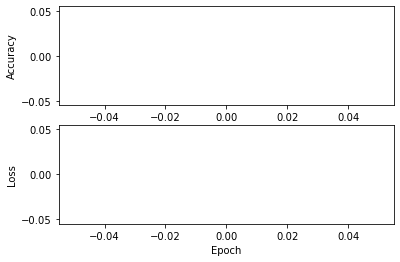

In [ ]:
plt.figure(1)

plt.subplot(211)
plt.plot(history_accuracy)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.subplot(212)
plt.plot(history_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')

#plt.title("Accuracy and Loss Over Time")

plt.show()

---
# Memory vs Accuracy Plot

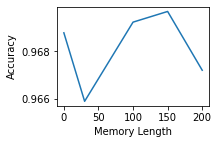

In [ ]:
plt.figure(2)
plt.subplot(222)
plt.plot(mem_lens_sorted, final_accuracies_sorted)
plt.xlabel('Memory Length')
plt.ylabel('Accuracy')
plt.show()